## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

import feather

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [3]:
universe_raw = feather.read_dataframe('bitcoin_data/factor_data/facotors_DBM_backtest.feather')
#universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y-%m-%d %H:%M:%S')
universe = universe_raw.set_index(['date']).sort_values(by=['date', 'ts_code'])
print(universe.shape)

(294307, 7)


In [4]:
universe.columns

Index(['ts_code', 'close', 'log-ret', 'trade_date', 'alpha_cci', 'alpha_rsi',
       'alpha_wt'],
      dtype='object')

In [5]:
# only use from 2023.2.27 to 2023.5.29, here use 48 hours to generate risk model from history
time_str = '2023-03-01 00:00:00'
time_timestamp = pd.to_datetime(time_str)
#start_time_timestamp = universe.index.unique()[0] - pd.DateOffset(hours=48)
start_time_timestamp = time_timestamp - pd.DateOffset(hours=100)
universe = universe.loc[universe.index>=start_time_timestamp].sort_values(by=['date', 'ts_code'])

In [6]:
start_time_timestamp

Timestamp('2023-02-24 20:00:00')

In [7]:
print(universe.index.unique()[0])
print(len(universe.ts_code.unique()))
set(universe.ts_code.unique()) - set(universe.loc[universe.index==universe.index.unique()[0]].ts_code.unique())

2023-02-24 20:00:00
35


set()

In [8]:
universe = universe.loc[universe.ts_code!='TUSDUSDT'].sort_values(by=['date', 'ts_code'])

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [10]:
import random
universe = universe.sort_values(by=['date', 'ts_code'])
all_factors = universe.copy(deep=True)
def return_handle(df):
    df['returns_2'] = df['close'].pct_change().shift(-1)
#     noise_list = []
#     for i in range(df.shape[0]):
#         noise = abs(random.gauss(0, 0.1))
#         if noise > 0.1:
#             noise=0.05
#         noise_list.append(noise)
#     df['returns_2'] = df['returns_2'] * (1-np.array(noise_list)) \
#                     + np.array(noise_list)*(df['close'].pct_change().shift(-1).fillna(0.))
    return df

all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(78960, 7) (78960, 8)


In [15]:
def keep_top_bottom(data, feature, bottom=0.45, top=0.55):
    tv = data[feature].quantile(top)
    bv = data[feature].quantile(bottom)
    data[feature] = np.where(data[feature]>=tv, data[feature], 
                            np.where(data[feature]<=bv, data[feature], 0))
    return data

def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.3, 0.3)
    all_factors_name = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors_name:
        #estu = keep_top_bottom(estu, factor_name)
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

#estimate_factor_returns(all_factors.loc[all_factors['trade_date']=='2023-05-01 00:00:00'])

In [16]:
universe.columns

Index(['ts_code', 'close', 'log-ret', 'trade_date', 'alpha_cci', 'alpha_rsi',
       'alpha_wt'],
      dtype='object')

In [17]:
base_field = ['ts_code', 'trade_date', 'log-ret', 'close']
date_and_code = [ 'ts_code', 'returns_2']

alpha_field = ['alpha_cci', 'alpha_rsi', 'alpha_wt'] 

#start_time = '2023-03-01 00:00:00'
start_time = time_str
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df.index>=start_time]
alpha_df = alpha_df.sort_values(by=['date', 'ts_code'])
calendar = alpha_df.index.unique() # int64

In [18]:
facret = {}
all_factors_new = pd.DataFrame()
for dt in tqdm(calendar, desc='factor returns regression'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[dt])
    new_df = all_factors.loc[dt]
    for alpha_col in alpha_field:
        new_df = keep_top_bottom(new_df, alpha_col)
    all_factors_new = all_factors_new.append(new_df)
    
facret[calendar[-5]]

factor returns regression: 100%|████████████| 2156/2156 [00:52<00:00, 41.40it/s]


alpha_cci    0.003612
alpha_rsi    0.001190
alpha_wt     0.005939
dtype: float64

#### Veiw Factor Returns

<AxesSubplot:xlabel='date'>

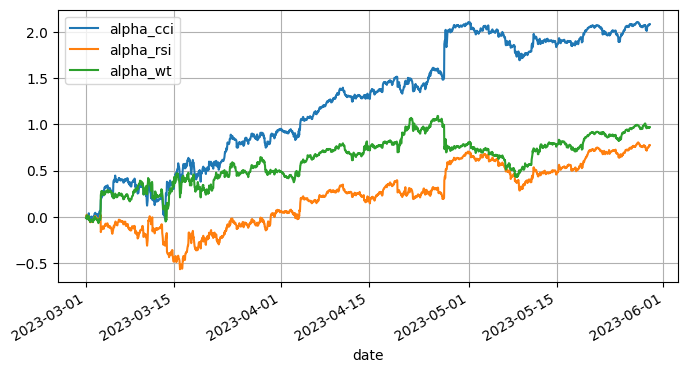

In [19]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]
        
facret_df = facret_df.sort_values(by=['date'])
# for column in alpha_field:
#     plt.plot(facret_df[column].cumsum(), label=column)
#     #plt.plot((1+facret_df[column]).cumprod(), label=column)
    
# plt.grid(True)
# plt.legend(loc='upper left')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Factor Returns')
# plt.show()
facret_df[alpha_field].cumsum().plot(grid=True)

### PCA model
We use PCA algorithm to estimate risk

In [20]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=100):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [21]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df.index<start_time].index.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.index.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df.index>=start_date) & (df.index<=end_date)]
        
def risk_by_PCA(returns_df):
#     for col in returns_df.columns:
#         returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 3
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector, F

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_fr, residual_i, F = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 100
return date 2023-03-01 00:00:00


ts_code,ACHUSDT,ADAUSDT,APEUSDT,APTUSDT,ATOMUSDT,AVAXUSDT,BNBUSDT,BTCUSDT,CFXUSDT,DOGEUSDT,...,NEARUSDT,OPUSDT,SANDUSDT,SHIBUSDT,SOLUSDT,STXUSDT,TRXUSDT,UMAUSDT,WOOUSDT,XRPUSDT
ts_code,,,,,,,,,,,,,,,,,,,,,
ACHUSDT,0.009516,0.001254,0.001907,0.001965,0.001257,0.001464,0.000798,0.000855,0.008088,0.000977,...,0.001692,0.001543,0.001834,0.001344,0.001501,0.003929,0.000344,0.000987,0.002023,0.000596
ADAUSDT,0.001254,0.000818,0.000906,0.000914,0.000657,0.000815,0.000437,0.000449,0.001846,0.000555,...,0.000886,0.000819,0.000954,0.000665,0.000869,0.000803,0.000287,0.001030,0.001019,0.000379
APEUSDT,0.001907,0.000906,0.001776,0.001249,0.000887,0.001095,0.000591,0.000606,0.002569,0.000743,...,0.001195,0.001087,0.001290,0.000895,0.001169,0.001662,0.000377,0.001336,0.001361,0.000500
APTUSDT,0.001965,0.000914,0.001249,0.001810,0.000894,0.001103,0.000595,0.000611,0.002654,0.000749,...,0.001205,0.001098,0.001300,0.000904,0.001176,0.001622,0.000378,0.001339,0.001375,0.000504
ATOMUSDT,0.001257,0.000657,0.000887,0.000894,0.000810,0.000792,0.000426,0.000437,0.001764,0.000539,...,0.000862,0.000788,0.000929,0.000645,0.000846,0.001037,0.000277,0.000991,0.000983,0.000365


In [22]:
h=np.array([1/35]*35) 
(np.dot(h, variance_i).dot(h.T))** 0.5

0.03369006259420145

In [23]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i, F = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:], residual_i.copy(), F]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 100
(75460, 3) (75460, 9)


### Combine Factors

In [24]:
#'alpha_cci', 'alpha_rsi', 'alpha_wt'
all_factors = all_factors_new.reset_index().copy(deep=True)
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['date', 'ts_code'])
alpha_df['alpha_all'] = alpha_df['alpha_cci']
#alpha_df['alpha_all'] = 0.5 * alpha_df['alpha_AI'] + 0.5*alpha_df['alpha_019']
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.0 -1.0


In [ ]:
# for dt in alpha_df.index.get_level_values(0).unique():
#     tmp = alpha_df.loc[dt]
#     print(tmp['trade_date'])

In [ ]:
alpha_df.index.get_level_values(0).unique()

### Backtest by Convex Optimization(Choice one option)

### Option One
- use `cvxpy` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed max risk to endure

In [25]:
calendar = alpha_df.index.get_level_values(0).unique()
ticker_num = len(alpha_df.index.get_level_values(1).unique())

# get parameter
positions = {}
alpha_df['h_privious'] = 0.
h0 = [0.] * ticker_num
aversion = 0.2
Lambda = 5e-4

In [ ]:
#alpha_df['alpha_019'].hist()
#variance_all[calendar[100]][4]

In [30]:
from helper.project_helper import OptimalHoldings

#dt = '2022-04-10 00:00:00'
dt = calendar[100]
obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==dt]
alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
optimal_weights = OptimalHoldings(aversion=aversion, weights_max=0.4, weights_min=-0.4, lambda_reg=1.).find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'], Lambda = Lambda)
optimal_weights.loc[optimal_weights[0].abs()>=0.005]

,0
ts_code,
APEUSDT,0.087124
APTUSDT,0.020812
ATOMUSDT,0.020872
AVAXUSDT,0.009407
BNBUSDT,0.055498
CFXUSDT,0.084057
DOGEUSDT,0.053966
DOTUSDT,0.042562
EGLDUSDT,0.053042


In [ ]:
calendar[1]

In [31]:
oh_obj = OptimalHoldings(aversion=aversion, weights_max=0.4, weights_min=-0.4, lambda_reg=.3)
for dt in tqdm(calendar, desc='optimized holding...'):
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==dt]
    alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
    # convex optimize
    optimal_weights = oh_obj.find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'],Lambda = Lambda)
    h_optimal = optimal_weights
    
    # update optimize holding
    #h_optimal[0] = np.where((h_optimal[0] - obj_df['h_privious']).abs() > 0.05, h_optimal, obj_df['h_privious'])
    obj_df['h_opt'] = h_optimal.values
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal.values

optimized holding...: 100%|█████████████████| 2156/2156 [03:13<00:00, 11.13it/s]


### Option Two
- use `scipy.optimize.fmin_l_bfgs_b` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk 1 posistion map to reduce how much risk

In [ ]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=5e-4, aversion=0.5): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * (np.dot(h, variance).dot(h.T)) \
             + np.dot((h-h0)**2, Lambda**2) \
             + 0.5 * alpha * np.linalg.norm(h) \

             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) \
                + 0.5 * 0.5 * alpha
        return f_hat
    return grad_func

# get parameter
bounds = [(-.25, .25)] * ticker_num

# for dt in calendar:
#     # fill yesterday holding
#     obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==dt]
#     # convex optimize
#     obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
#     #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
#     # update optimize holding
#     obj_df['h_opt'] = h_optimal
#     obj_df['h_privious'] = h0
#     positions[dt]= obj_df
#     h0 = h_optimal

In [32]:
import copy
positions_bak = copy.deepcopy(positions)

In [47]:
positions = copy.deepcopy(positions_bak)

1.0000000000054499 -0.9999999999995025
0.006004552752818286 3.236465295446658e-13


<AxesSubplot:>

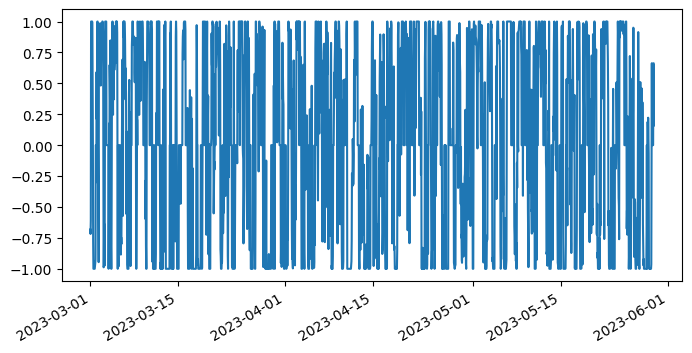

In [48]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
#calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=calendar).plot()

### Money to optimal weights

In [50]:
holding_money = 1e5
for i in positions.keys():
    change_sr = (positions[i]['h_opt'] - positions[i]['h_privious']).abs()
    positions[i]['h_opt'] = np.where(change_sr <= 0.01, 
                                     positions[i]['h_privious'], positions[i]['h_opt'])
    
    positions[i]['h_opt'] = positions[i]['h_opt'] * holding_money
    positions[i]['h_privious'] = positions[i]['h_privious'] * holding_money

In [51]:
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

83652.78894997017 (30, 9)


close   log-ret    h_privious        h_opt
date                ts_code                                                
2023-05-29 19:00:00 ACHUSDT   1.599336  0.004856  1.896886e+03  3907.787819
                    ADAUSDT   0.602988  0.002111  3.454022e+03  3454.021629
                    APEUSDT   0.475657  0.004288  4.376218e+03  3275.313107
                    APTUSDT   0.998199  0.007220  2.956743e+03  1047.729645
                    ATOMUSDT  1.044573  0.002025  1.099438e+03  2447.806548
                    AVAXUSDT  0.549196  0.002046  5.416733e+03  5416.732747
                    BNBUSDT   0.976146  0.004772  1.619288e+03 -3404.578010
                    BTCUSDT   0.868022  0.002018  4.280016e+03  4280.015526
                    CFXUSDT   3.744186  0.004669  6.975812e+03  6975.811714
                    DOGEUSDT  0.854677  0.002733  3.418928e+03  3418.927787
                    DYDXUSDT  1.020914  0.002863  3.941308e+02  1813.316069
                    EGLDUSDT  0.450171  0.005972  3.397085e-07 -1688.904677
                    ETHUSDT   0.964579  0.000972  3.601488e+02  1626.498014
                    FILUSDT   0.575806  0.001294  3.300273e+03  6491.742730
                    FTMUSDT   0.835173  0.006482  5.251468e+03  4232.604823
                    GALAUSDT  0.369654  0.005540  4.055229e+03  2826.380480
                    GMTUSDT   0.231583  0.003350  1.505213e+03  3269.471919
                    LINKUSDT  0.882667  0.003935  1.729018e+03  1729.018304
                    LTCUSDT   1.334061  0.002841 -4.152521e+03 -1256.089131
                    LUNCUSDT  0.174430  0.000228 -6.885260e-10  4545.366453
                    MANAUSDT  0.445050  0.006877  4.442063e+03  3362.613272
                    MASKUSDT  2.228664  0.007520 -4.568495e+03 -6179.898531
                    NEARUSDT  0.272984  0.007934  5.673610e+03  4046.777469
                    SANDUSDT  0.385405  0.009467 -1.724931e-09  1088.887533
                    SHIBUSDT  0.745148  0.004540 -4.915806e+02 -1631.682333
                    SOLUSDT   0.448432  0.002897 -7.478641e-10  3242.621355
                    STXUSDT   1.128496  0.005820 -2.249922e+03 -2249.922097
                    UMAUSDT   0.608735  0.001981  5.002066e+03  5002.066272
                    WOOUSDT   1.280543  0.006647 -2.870115e+03  1355.710420
                    XRPUSDT   1.157274  0.002709  4.244144e+03  4244.143991

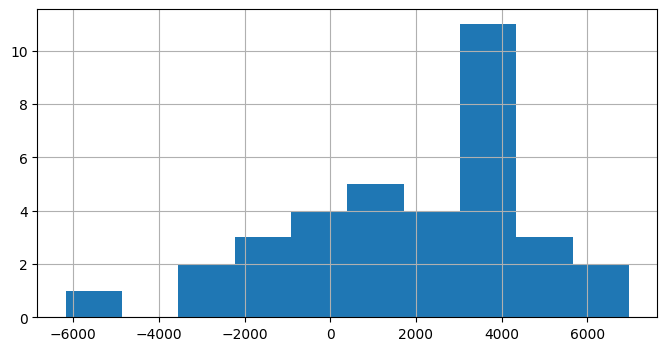

In [52]:
date_hold = list(positions.keys())[-2]
positions[date_hold]['h_opt'].hist()
tmp = positions[date_hold].loc[(positions[date_hold]['h_opt']>1000) | (positions[date_hold]['h_opt']<-1000)]
print(positions[date_hold].loc[positions[date_hold]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

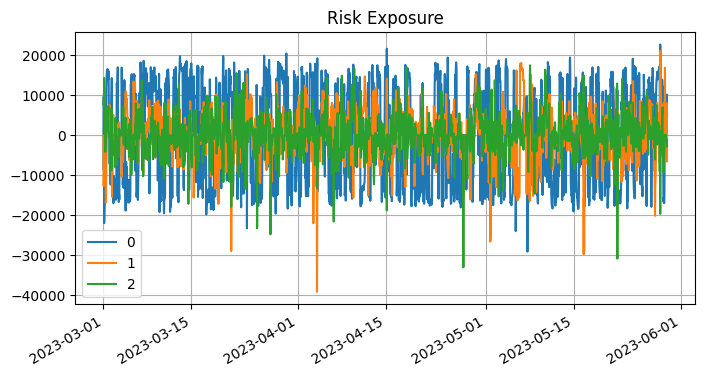

In [53]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y-%m-%d %H:%M:%S'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

In [54]:
all_factors = all_factors_new
universe.ts_code.unique()

array(['ACHUSDT', 'ADAUSDT', 'APEUSDT', 'APTUSDT', 'ATOMUSDT', 'AVAXUSDT',
       'BNBUSDT', 'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT',
       'EGLDUSDT', 'ETHUSDT', 'FILUSDT', 'FTMUSDT', 'GALAUSDT', 'GMTUSDT',
       'LINKUSDT', 'LTCUSDT', 'LUNCUSDT', 'MAGICUSDT', 'MANAUSDT',
       'MASKUSDT', 'MATICUSDT', 'NEARUSDT', 'OPUSDT', 'SANDUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'TRXUSDT', 'UMAUSDT', 'WOOUSDT',
       'XRPUSDT'], dtype=object)

### Alpha Exposure

<AxesSubplot:>

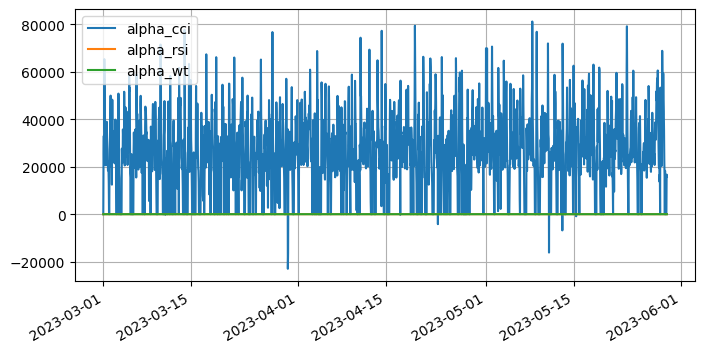

In [55]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code',
                            'alpha_cci', 'alpha_rsi', 'alpha_wt', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    B_alpha = B_alpha * [[1., 0., 0.]] 
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=[
                    'alpha_cci', 'alpha_rsi', 'alpha_wt'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y-%m-%d %H:%M:%S'), inplace=True)
alpha_exposure_df.plot(grid=True)

In [56]:
len(h_optimal_list)

2156

8303.468911763559 46751.212208063036


<AxesSubplot:>

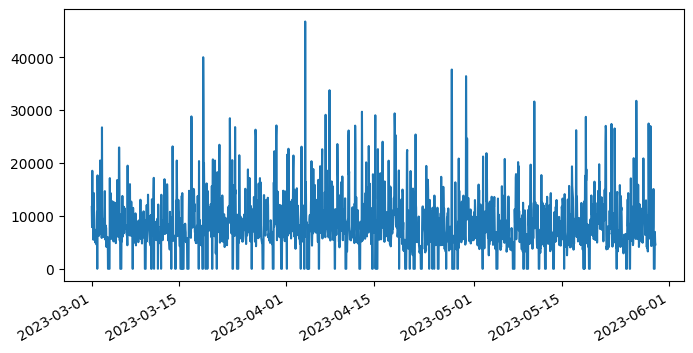

In [57]:
retre_list = []
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    retre_list.append(tmp_change.abs().max())
print(np.sum(retre_list)/len(h_optimal_list), np.max(retre_list))
pd.Series(retre_list, index=pd.to_datetime(calendar[1:], format='%Y%m%d %H:%M:%S')).plot()

70990.0822512799


<AxesSubplot:>

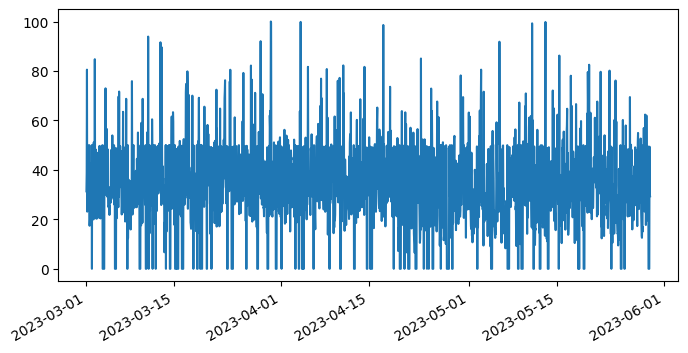

In [58]:
transaction_costs = []
Lambda = 5e-4
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    costs = sum(np.dot(tmp_change**2, Lambda**2)**0.5)
    #costs = sum(abs(tmp_change) * Lambda)
    transaction_costs.append(costs)
print(np.sum(transaction_costs))
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d %H:%M:%S')).plot()

### Profit-and-Loss (PnL)

In [80]:
benchmark_return = all_factors.loc[all_factors.ts_code=='BTCUSDT']
benchmark_return.tail()

,ts_code,close,log-ret,trade_date,alpha_cci,alpha_rsi,alpha_wt,returns_2
date,,,,,,,,
2023-05-29 16:00:00,BTCUSDT,0.867609,-0.000260,2023-05-29 16:00:00,0.061069,0.036330,0.374993,0.001410
2023-05-29 17:00:00,BTCUSDT,0.868833,0.001409,2023-05-29 17:00:00,0.000000,-0.080776,0.370441,-0.002948
2023-05-29 18:00:00,BTCUSDT,0.866272,-0.002952,2023-05-29 18:00:00,0.222136,0.158199,0.387396,0.002020
2023-05-29 19:00:00,BTCUSDT,0.868022,0.002018,2023-05-29 19:00:00,0.221667,-0.019569,0.344709,0.001283
2023-05-29 20:00:00,BTCUSDT,0.869136,0.001282,2023-05-29 20:00:00,0.146544,-0.122441,0.233108,0.000000


2023-05-29 18:00:00


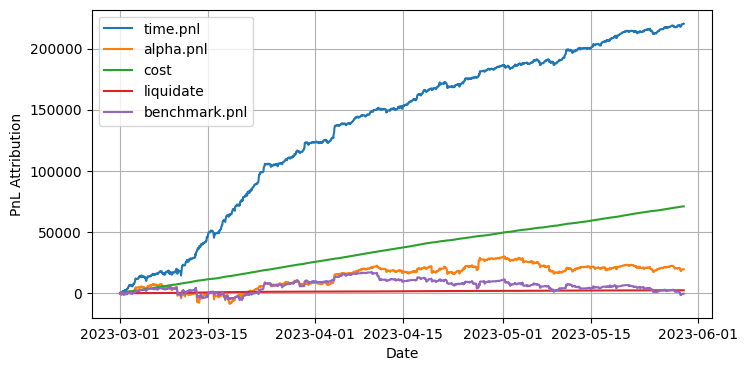

In [103]:
all_factors['date'] = all_factors['trade_date']
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = all_factors['trade_date'].unique()).iloc[:-2,:]
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    stop_loss_holding = []
    for ii, dt, time_i in zip(counter,calendar, df.index):
        # holding frame
        p = positions[time_i]
        # alpha f
        fr = facret[time_i].loc[['alpha_cci', 'alpha_rsi', 'alpha_wt']]
        # risk f
        rr = variance_all[time_i][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")
        #mf['returns_2'] = wins(mf['returns_2'], -0.05, 0.05)
        liquidate_position = mf.loc[(mf['returns_2'] * np.sign(mf['h_opt']))<-0.02]['h_opt'].abs().sum()
        mf['returns_2'] = np.where((mf['returns_2'] * np.sign(mf['h_opt']))<-0.02, -0.02, mf['returns_2'])
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[time_i])
        #df.at[time_i,"risk.pnl"] = np.sum(rr.values * risk_exposures[dt].values)/(-1)
        df.at[time_i,"cost"] = transaction_costs[ii]
        if liquidate_position>0:
            df.at[time_i,"liquidate"] = liquidate_position * 5e-4
        else:
            df.at[time_i,"liquidate"] = 0
        df.at[time_i,"benchmark.pnl"] = positions[time_i]['h_opt'].sum() * \
                            benchmark_return.loc[benchmark_return.index==dt]['returns_2'].values[0]
    
    print(time_i)
    return stop_loss_holding, df

stop_loss, attr = build_pnl_attribution()
plt.grid(True)
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [109]:
# 回撤手续费
attr['liquidate'].cumsum()[-1]

2384.3865584293835

In [106]:
# 总收益
attr['time.pnl'].sum()

220274.263054995

In [66]:
# 最小余额
attr['time.pnl'].cumsum().min()

-636.1851420224419

In [67]:
# 最大余额时间
attr['time.pnl'].cumsum().idxmax()

Timestamp('2023-05-29 18:00:00')

In [68]:
# 因子归因收益
attr['alpha.pnl'].sum()

19532.575978892048

In [69]:
# 因子夏普比率
(np.sqrt(252 * 12) * attr['alpha.pnl'].mean()- 0.00017*100000)/attr['alpha.pnl'].std()

0.9618552312261625

In [71]:
# 回测夏普比率
(np.sqrt(2156)* attr['time.pnl'].mean() - 0.00017*100000)/attr['time.pnl'].std()

9.522048889833433

In [72]:
# 最大回撤比例及时间
portfolio_values = (100000 + attr['time.pnl'])
retre = ((portfolio_values.cummax() - portfolio_values.cummin())/portfolio_values.cummax())
max_retre_val = retre.max()
max_retre_time = retre.idxmax()
print(max_retre_time, max_retre_val)

2023-04-04 03:00:00 0.05017387192718148


In [73]:
# 胜率
attr.loc[attr['time.pnl']>0].shape[0]/attr.shape[0]

0.6035283194057567

In [74]:
# 平均盈利比率
attr.loc[attr['time.pnl']>0]['time.pnl'].sum()/attr.shape[0]

209.15400685294347

In [75]:
# 每笔交易损耗
np.sum(transaction_costs)/attr.shape[0]

32.95732695045493

In [76]:
# 平均每笔收益
attr['time.pnl'].sum()/attr.shape[0]

102.26288906917131

In [77]:
attr['time.pnl'].cumsum().max()

220274.26305499527

In [78]:
attr.shape

(2154, 3)

In [79]:
open_cap = pd.Series()
close_cap = pd.Series()
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    tmp_change = tmp_change[abs(tmp_change)>1000]
    open_cap = open_cap.append(tmp_change[tmp_change>0])
    close_cap = close_cap.append(tmp_change[tmp_change<0])

In [ ]:
open_cap.sum() - close_cap.sum()

In [ ]:
close_cap.size + open_cap.size